# DPF on MVSA Single Dataset & Ablation


In [1]:
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import sys
sys.path.append('./cs16')
import cs16.prep as prep16
import cs16.plot as plot16
import cs16.build as build16
imagesize = 64

import pandas as pd

import cs16.prep as prep16
import cs16.plot as plot16
import cv2
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
max_words=10000
max_len=100
imagesize =64

#data_type = input("Enter '1. single' for single dataset or '2. multi' for multiple dataset: ")
data_type = '1'
if data_type == '1':
    file_path = 'single.txt'
    folder_path = './data/MVSA/single/'
elif data_type == '2':
    file_path = 'multi.txt'
    folder_path = './data/MVSA/multiple/'
else:
    print("Invalid input. Please enter either 'single' or 'multi'.")
    exit()

df = pd.read_csv(file_path, index_col=None, encoding='ISO-8859-1')

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt

# Download stopwords and punkt tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define a function to preprocess text
def nlp_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs using regex
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stem words using Porter Stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text

# Apply the preprocess_text function to the 'tweet' column of the dataframe
df['tweet'] = df['tweet'].apply(nlp_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
X_text, y_text = prep16.preprocess_text(df)
X_train_text, X_val_text, X_test_text, \
y_train_text, y_val_text, y_test_text = prep16.split_data(X_text, y_text, random_state=42)

X_polar, y_polar = prep16.preprocess_text(df,label = 'polarity')
X_train_polar, X_val_polar, X_test_polar, \
y_train_polar, y_val_polar, y_test_polar = prep16.split_data(X_polar, y_polar, random_state=42)

image_data_s, image_label_s = prep16.preprocess_images(df, folder_path, imagesize)
y_s = to_categorical(image_label_s, num_classes=3)

X_train_image, X_val_image, X_test_image, \
y_train_image, y_val_image, y_test_image= prep16.split_data(image_data_s, y_s, random_state=42)

y_train = to_categorical(y_train_polar, num_classes=3)
y_val =to_categorical(y_val_polar, num_classes=3)
y_test =to_categorical(y_test_polar, num_classes=3)
file_path

'single.txt'

# DPF ( Dynamic Probabilistic Fusion)

### TOP-K+ ADAPTIVE Epsilon
（Last use: 2025/05/09）

In [4]:
import numpy as np
import xgboost as xgb
import time
from sklearn.ensemble import ExtraTreesClassifier
def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    """
    Calculate dynamic weights for two modalities using Top-k Approximate Rényi-2 entropy
    with adaptive epsilon regularization for numerical stability.

    Args:
        prob1 (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        prob2 (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Number of top probabilities to consider for entropy approximation.
        delta (float): Scaling factor for adaptive epsilon, relative to maximum squared probability.

    Returns:
        weights (ndarray): Normalized modality weights, shape (n_samples, 2)
    """
    # Select Top-k largest probabilities
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]  # shape: (n_samples, topk)
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]

    # Compute adaptive epsilon based on maximum p² in Top-k
    max_p2_text = np.max(topk_prob1**2, axis=1, keepdims=True)  # shape: (n_samples, 1)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)

    adaptive_eps_text = delta * max_p2_text  # epsilon for text modality
    adaptive_eps_image = delta * max_p2_image  # epsilon for image modality

    # Compute energy (negative log collision probability)
    energy_text = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + adaptive_eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + adaptive_eps_image).flatten()

    # Compute normalized weights via Gibbs-style softmax
    energies = np.vstack([energy_text, energy_image]).T  # shape: (n_samples, 2)
    weights = np.exp(-beta * energies)
    weights /= np.sum(weights, axis=1, keepdims=True)

    return weights

def enhanced_dynamic_fusion_topk_adaptive(probs_text, probs_image, beta=0.1, topk=2, delta=1e-4):
    """
    Perform enhanced fusion by dynamically weighting two modalities and concatenating
    their weighted outputs, preserving modality-specific information.

    Args:
        probs_text (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        probs_image (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Top-k approximation size.
        delta (float): Adaptive epsilon scaling factor.

    Returns:
        enhanced_fused_probs (ndarray): Concatenated weighted probability vectors, shape (n_samples, 2*n_classes)
    """
    weights = dynamic_weight_topk_adaptive(probs_text, probs_image, beta, topk, delta)
    fused_text = weights[:, 0:1] * probs_text  # weight applied to text probabilities
    fused_image = weights[:, 1:2] * probs_image  # weight applied to image probabilities
    enhanced_fused_probs = np.concatenate([fused_text, fused_image], axis=1)
    return enhanced_fused_probs


# MAIN
(last use:2025/05/09)

In [5]:

start_time = time.time()
#------------------------------------------------------------

########################################
# 1. one-hot 
########################################
y_train_int = np.argmax(y_train, axis=1)
y_val_int   = np.argmax(y_val,   axis=1)
y_test_int  = np.argmax(y_test,  axis=1)

########################################
# 2. Text Modality：Original RandomForest-> ExtraTree，Prob Vector(3-dim)
########################################
rf_text = ExtraTreesClassifier(n_estimators=100, random_state=42)

rf_text.fit(X_train_text, y_train_int)

# Each sample will get [p_neg, p_neu, p_pos]
train_probs_text = rf_text.predict_proba(X_train_text)  # shape -> (n_train, 3)
val_probs_text   = rf_text.predict_proba(X_val_text)    # shape -> (n_val,   3)
test_probs_text  = rf_text.predict_proba(X_test_text)   # shape -> (n_test,  3)

########################################
# 3. Image Modality：
########################################
X_train_img_flat = X_train_image.reshape(X_train_image.shape[0], -1)
X_val_img_flat   = X_val_image.reshape(X_val_image.shape[0],   -1)
X_test_img_flat  = X_test_image.reshape(X_test_image.shape[0], -1)

rf_image = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=12,#12
    min_samples_leaf=6, #6
    max_features='sqrt', #'sqrt'
    class_weight='balanced',#'balanced'
    random_state=42,
    bootstrap=True # 可以試試開啟
)
#ExtraTreesClassifier(n_estimators=100, max_features='sqrt',min_samples_leaf=6,bootstrap=True, random_state=42)
rf_image.fit(X_train_img_flat, y_train_int)

train_probs_image = rf_image.predict_proba(X_train_img_flat)  # (n_train, 3)
val_probs_image   = rf_image.predict_proba(X_val_img_flat)    # (n_val,   3)
test_probs_image  = rf_image.predict_proba(X_test_img_flat)   # (n_test,  3)

########################################
# 4. Global Fusion：concatenation Text(3D) + Image(3D) -> 6 D
########################################
beta = 1
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(350, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# TEST set
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))

#------------------------------------------------------------

end_time = time.time()
elapsed_time = end_time - start_time

# TIME TAKEN
print(f"Time Executed ===============>：{elapsed_time:.4f} Sec")

Dynamic Fusion Feature shape (train): (3895, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.5708418891170431
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.4074    0.1429    0.2115        77
     neutral     0.6294    0.7698    0.6926       278
    positive     0.4417    0.4015    0.4206       132

    accuracy                         0.5708       487
   macro avg     0.4928    0.4381    0.4416       487
weighted avg     0.5434    0.5708    0.5428       487

Time Executed ===============>：5.7334 Sec


In [24]:
# # 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 1.1
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(300, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (3895, 6)
Test Accuracy: 0.5585215605749486
Test Classification Report:


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


              precision    recall  f1-score   support

    negative     0.3571    0.1299    0.1905        77
     neutral     0.6196    0.7734    0.6880       278
    positive     0.4196    0.3561    0.3852       132

    accuracy                         0.5585       487
   macro avg     0.4655    0.4198    0.4212       487
weighted avg     0.5239    0.5585    0.5273       487



# delta =0 （No Regularzation）

In [29]:
# # 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 1
topk=2
delta =0

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(300, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (3895, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.5687885010266941
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.4000    0.1299    0.1961        77
     neutral     0.6257    0.7698    0.6903       278
    positive     0.4417    0.4015    0.4206       132

    accuracy                         0.5688       487
   macro avg     0.4891    0.4337    0.4357       487
weighted avg     0.5402    0.5688    0.5391       487



# beta = 0 （No Dynamic Weighting）

In [34]:
########################################
# 4. Global Fusion：Concate Text(3-D) + Image(3-D) -> 6 Dimension
########################################
beta = 0
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(350, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (3895, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.5626283367556468
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.5333    0.1039    0.1739        77
     neutral     0.6037    0.8165    0.6942       278
    positive     0.4062    0.2955    0.3421       132

    accuracy                         0.5626       487
   macro avg     0.5144    0.4053    0.4034       487
weighted avg     0.5391    0.5626    0.5165       487



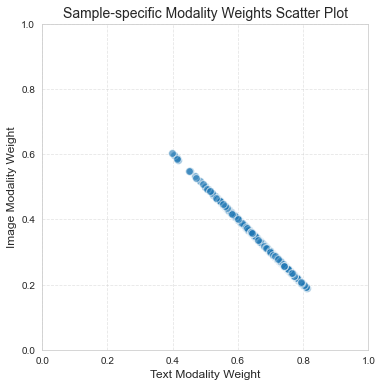

In [31]:
import matplotlib.pyplot as plt

def plot_modality_weights_scatter(weights):
    plt.figure(figsize=(8, 6))
    plt.scatter(weights[:, 0], weights[:, 1], alpha=0.6, edgecolors='w', s=60)
    plt.title("Sample-specific Modality Weights Scatter Plot", fontsize=14)
    plt.xlabel("Text Modality Weight", fontsize=12)
    plt.ylabel("Image Modality Weight", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# plot_modality_weights_scatter(weights)

wx = dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
plot_modality_weights_scatter(wx)

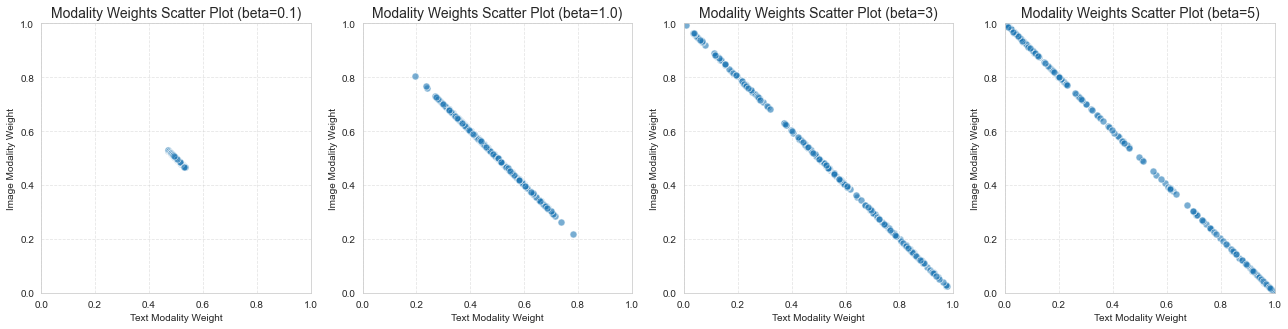

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_weights(beta, n_samples=200):
    # (n_samples, n_classes=5)
    probs_text = np.random.dirichlet(np.ones(5), size=n_samples)
    probs_image = np.random.dirichlet(np.ones(5), size=n_samples)

    # Top-k = 2
    topk = 2
    delta = 1e-4

    # Top-k ranking
    topk_prob_text = np.sort(probs_text, axis=1)[:, -topk:]
    topk_prob_image = np.sort(probs_image, axis=1)[:, -topk:]

    # adaptive epsilon
    adaptive_eps_text = delta * np.max(topk_prob_text**2, axis=1, keepdims=True)
    adaptive_eps_image = delta * np.max(topk_prob_image**2, axis=1, keepdims=True)

    # energy計算
    energy_text = -np.log(np.sum(topk_prob_text**2, axis=1, keepdims=True) + adaptive_eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob_image**2, axis=1, keepdims=True) + adaptive_eps_image).flatten()

    # Gibbs softmax
    energies = np.vstack([energy_text, energy_image]).T
    weights = np.exp(-beta * energies)
    weights /= np.sum(weights, axis=1, keepdims=True)

    return weights

# 畫散點圖函數
def plot_weights_scatter(weights, beta):
    plt.scatter(weights[:, 0], weights[:, 1], alpha=0.6, edgecolors='w', s=50)
    plt.title(f"Modality Weights Scatter Plot (beta={beta})", fontsize=14)
    plt.xlabel("Text Modality Weight")
    plt.ylabel("Image Modality Weight")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')

betas = [0.1, 1.0, 3, 5]
plt.figure(figsize=(18, 5))
for i, beta in enumerate(betas):
    plt.subplot(1, 4, i+1)
    w = simulate_weights(beta)
    plot_weights_scatter(w, beta)
plt.tight_layout()
plt.show()


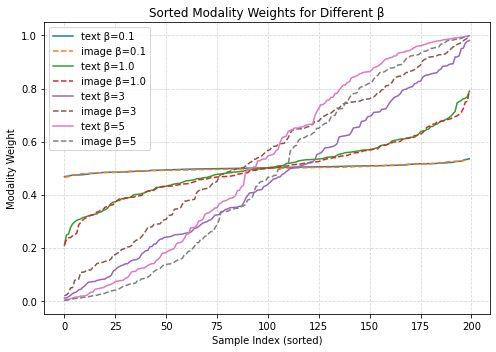

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
for b in betas:
    w = simulate_weights(b, n_samples=200)
    # Seperate
    txt = np.sort(w[:,0])
    img = np.sort(w[:,1])
    # Two curve，text (line)，image (dot line)
    plt.plot(txt,       label=f"text β={b}")
    plt.plot(img, linestyle="--", label=f"image β={b}")

plt.xlabel("Sample Index (sorted)")
plt.ylabel("Modality Weight")
plt.title("Sorted Modality Weights for Different β")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


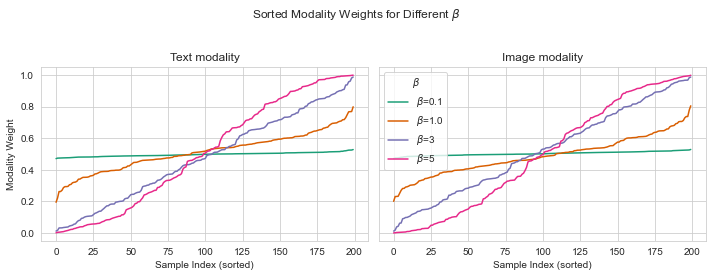

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
palette = sns.color_palette("Dark2", len(betas))

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)

for i, b in enumerate(betas):
    w = simulate_weights(b, n_samples=200)
    txt = np.sort(w[:,0])
    img = np.sort(w[:,1])
    axes[0].plot(txt, color=palette[i], label=f"$\\beta$={b}")
    axes[1].plot(img, color=palette[i], label=f"$\\beta$={b}")

axes[0].set_title("Text modality")
axes[1].set_title("Image modality")
for ax in axes:
    ax.set_xlabel("Sample Index (sorted)")
axes[0].set_ylabel("Modality Weight")

# on side
axes[1].legend(title=r"$\beta$", frameon=True)
plt.suptitle("Sorted Modality Weights for Different $\\beta$")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


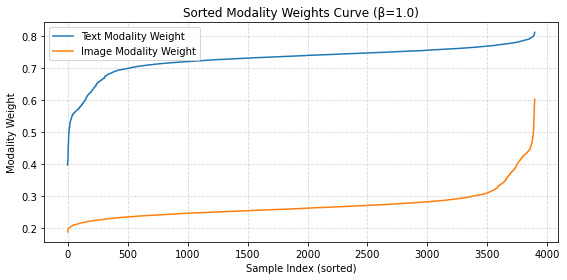

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- DEF dynamic_weight_topk_adaptive ---
def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]
    max_p2_text  = np.max(topk_prob1**2, axis=1, keepdims=True)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)
    eps_text  = delta * max_p2_text
    eps_image = delta * max_p2_image
    e_text  = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + eps_text).flatten()
    e_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + eps_image).flatten()
    E = np.vstack([e_text, e_image]).T
    w = np.exp(-beta * E)
    w /= w.sum(axis=1, keepdims=True)
    return w

# --- trial ---
# train_probs_text  = np.random.rand(200, 5)
# train_probs_image = np.random.rand(200, 5)

# Calculate Dynamic Weighting
weights = dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta=1.0, topk=2, delta=1e-4)
text_weights  = weights[:, 0]
image_weights = weights[:, 1]

# Sorting
text_sorted  = np.sort(text_weights)
image_sorted = np.sort(image_weights)

# Drawing
plt.figure(figsize=(8, 4))
plt.plot(text_sorted, label='Text Modality Weight')
plt.plot(image_sorted, label='Image Modality Weight')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Modality Weight')
plt.title('Sorted Modality Weights Curve (β=1.0)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


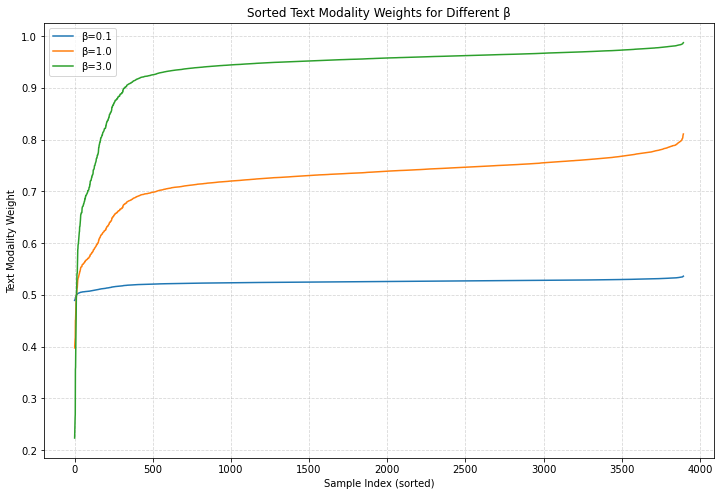

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]
    max_p2_text  = np.max(topk_prob1**2, axis=1, keepdims=True)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)
    eps_text  = delta * max_p2_text
    eps_image = delta * max_p2_image
    energy_text  = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + eps_image).flatten()
    E = np.vstack([energy_text, energy_image]).T
    W = np.exp(-beta * E)
    W /= np.sum(W, axis=1, keepdims=True)
    return W


# Pre-setting values
betas = [0.1, 1.0, 3.0]

plt.figure(figsize=(12, 8))
for beta in betas:
    weights = dynamic_weight_topk_adaptive(
        train_probs_text, train_probs_image,
        beta=beta, topk=2, delta=1e-4
    )
    w_text_sorted = np.sort(weights[:, 0])
    plt.plot(w_text_sorted, label=f'β={beta}')

plt.xlabel('Sample Index (sorted)')
plt.ylabel('Text Modality Weight')
plt.title('Sorted Text Modality Weights for Different β')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


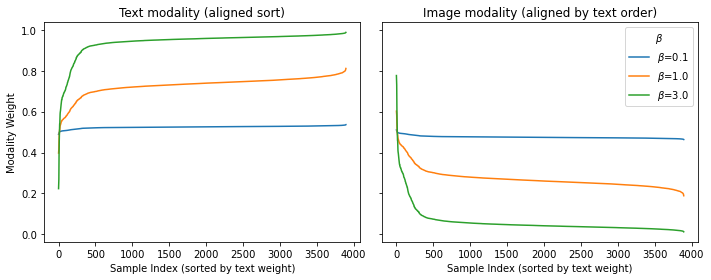

In [6]:
# 1) Real Weights in the data（Same data with Fig.5 in the REPORT ）
betas = [0.1, 1.0, 3.0]  # 5
W = {b: dynamic_weight_topk_adaptive(train_probs_text, train_probs_image,
                                     beta=b, topk=2, delta=1e-4) for b in betas}

# 2) Sorting（eg text sorting by weights）
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
for b in betas:
    w = W[b]
    idx = np.argsort(w[:,0])         #  text weight sorting
    txt = w[idx, 0]                  # Sorted text weighting
    img = w[idx, 1]                  # 
    axes[0].plot(txt, label=fr"$\beta$={b}")
    axes[1].plot(img, label=fr"$\beta$={b}")

axes[0].set_title("Text modality (aligned sort)")
axes[1].set_title("Image modality (aligned by text order)")
for ax in axes: ax.set_xlabel("Sample Index (sorted by text weight)")
axes[0].set_ylabel("Modality Weight")
axes[1].legend(title=r"$\beta$")
plt.tight_layout(); plt.show()